In [18]:
import pandas as pd

# 전처리 CSV 파일 불러오기 
df = pd.read_csv('wildfire_preprocessed_4_logs_target.csv')

# 데이터 첫 5행 확인
print(df.head())

   DSPT_REQ_HR  HR_UNIT_ARTMP  HR_UNIT_HUM  WSPD_BIN  MONTH  \
0          246           -1.0         39.0         1      1   
1          253            5.0         60.0         1      3   
2          643            7.0         49.0         1      3   
3          578            0.3         48.0         3      3   
4          874           -8.7         36.0         5     12   

   CMBS_EXPOBJ_LCLSF_NM_가연성가스  CMBS_EXPOBJ_LCLSF_NM_기타  \
0                           0                        0   
1                           0                        0   
2                           0                        0   
3                           0                        0   
4                           0                        0   

   CMBS_EXPOBJ_LCLSF_NM_미상  CMBS_EXPOBJ_LCLSF_NM_쓰레기류  \
0                        0                          0   
1                        0                          0   
2                        0                          0   
3                        0                  

In [19]:
df.head()

,DSPT_REQ_HR,HR_UNIT_ARTMP,HR_UNIT_HUM,WSPD_BIN,MONTH,CMBS_EXPOBJ_LCLSF_NM_가연성가스,CMBS_EXPOBJ_LCLSF_NM_기타,CMBS_EXPOBJ_LCLSF_NM_미상,CMBS_EXPOBJ_LCLSF_NM_쓰레기류,CMBS_EXPOBJ_LCLSF_NM_위험물등,...,WNDRCT_BRNG_남서,WNDRCT_BRNG_동,WNDRCT_BRNG_북,WNDRCT_BRNG_북동,WNDRCT_BRNG_북서,WNDRCT_BRNG_서,ARRIVAL_DELAY_MIN_LOG,CNTR_GRNDS_DSTNC_LOG,FRSTN_GRNDS_DSTNC_LOG,FIRE_SUPESN_HR_LOG
0,246,-1.0,39.0,1,1,0,0,0,0,0,...,0,0,0,0,1,0,3.044522,1.609438,2.484907,7.090910
1,253,5.0,60.0,1,3,0,0,0,0,0,...,1,0,0,0,0,0,2.397895,1.098612,1.609438,6.398595
2,643,7.0,49.0,1,3,0,0,0,0,0,...,1,0,0,0,0,0,3.230145,1.791759,2.302585,7.284821
3,578,0.3,48.0,3,3,0,0,0,0,0,...,0,0,0,0,1,0,3.276516,1.098612,1.791759,7.333023
4,874,-8.7,36.0,5,12,0,0,0,0,0,...,0,0,0,0,0,1,4.852551,2.397895,3.295837,9.579487


In [8]:
! pip3 install lightgbm

Defaulting to user installation because normal site-packages is not writeable


In [5]:
# 1) libomp 설치
import subprocess, os, sys, platform
subprocess.run("brew install libomp", shell=True, check=False)

# 2) 런타임에 로더가 찾도록 경로 반영 (Apple Silicon 기준 경로)
libomp_path = "/opt/homebrew/opt/libomp/lib/libomp.dylib" if platform.machine() != "x86_64" else "/usr/local/opt/libomp/lib/libomp.dylib"

# (선택) 직접 로드해서 의존성 해결
import ctypes
try:
    ctypes.CDLL(libomp_path, mode=ctypes.RTLD_GLOBAL)
except OSError as e:
    print("libomp 로드 실패:", e)

# 3) 이제 lightgbm 임포트
import lightgbm as lgb
print("LightGBM OK:", lgb.__version__)


LightGBM OK: 4.6.0


To reinstall 20.1.8, run:
  brew reinstall libomp


In [11]:
import platform, ctypes
libomp = "/opt/homebrew/opt/libomp/lib/libomp.dylib" if platform.machine() != "x86_64" else "/usr/local/opt/libomp/lib/libomp.dylib"
ctypes.CDLL(libomp, mode=ctypes.RTLD_GLOBAL)


<CDLL '/opt/homebrew/opt/libomp/lib/libomp.dylib', handle dc745200 at 0x1607fa640>

In [20]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import lightgbm as lgb
from lightgbm import LGBMRegressor, early_stopping  # (옵션) log_evaluation도 필요시 추가

from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


In [21]:
# 파일 경로
CSV_PATH = "wildfire_preprocessed_4_logs_target.csv"

# 예측 시점 선택에 따라 누수 변수 포함/제외 토글
# True  -> 도착 이후 시점(허용),  ARRIVAL_DELAY_MIN_LOG 포함
# False -> 발생 직후 시점(비허용), ARRIVAL_DELAY_MIN_LOG 제외
INCLUDE_LEAKY = True

# 데이터 로드
df = pd.read_csv(CSV_PATH)

print(f"행: {len(df):,}, 열: {len(df.columns)}")
print("\n컬럼명:\n", df.columns.tolist()[:50], " ...")
display(df.head())

# 타깃/피처 선택
TARGET = "FIRE_SUPESN_HR_LOG"
if TARGET not in df.columns:
    raise ValueError(f"'{TARGET}' 컬럼이 없습니다.")

# 숫자형 컬럼만 사용(원-핫 완료 가정)
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
feature_cols = [c for c in numeric_cols if c != TARGET]

# 필요 시 누수 변수 제거
if not INCLUDE_LEAKY and "ARRIVAL_DELAY_MIN_LOG" in feature_cols:
    feature_cols.remove("ARRIVAL_DELAY_MIN_LOG")

X = df[feature_cols].copy()
y = df[TARGET].copy()

# 결측치 처리(있으면 행 제거)
mask = ~(X.isnull().any(axis=1) | y.isnull())
X = X[mask]
y = y[mask]

print(f"\n최종 데이터 크기: X={X.shape}, y={y.shape}")
print(f"누수 변수 포함 여부(INCLUDE_LEAKY) = {INCLUDE_LEAKY}")

행: 3,359, 열: 62

컬럼명:
 ['DSPT_REQ_HR', 'HR_UNIT_ARTMP', 'HR_UNIT_HUM', 'WSPD_BIN', 'MONTH', 'CMBS_EXPOBJ_LCLSF_NM_가연성가스', 'CMBS_EXPOBJ_LCLSF_NM_기타', 'CMBS_EXPOBJ_LCLSF_NM_미상', 'CMBS_EXPOBJ_LCLSF_NM_쓰레기류', 'CMBS_EXPOBJ_LCLSF_NM_위험물등', 'CMBS_EXPOBJ_LCLSF_NM_자동차,철도차량,선박,항공기', 'CMBS_EXPOBJ_LCLSF_NM_전기,전자', 'CMBS_EXPOBJ_LCLSF_NM_종이,목재,건초등', 'CMBS_EXPOBJ_LCLSF_NM_침구,직물류', 'CMBS_EXPOBJ_LCLSF_NM_합성수지', 'CMBS_EXPOBJ_LCLSF_NM_nan', 'IGTN_HTSRC_NM_기타(발화원인)', 'IGTN_HTSRC_NM_담뱃불, 라이터불', 'IGTN_HTSRC_NM_마찰, 전도, 복사', 'IGTN_HTSRC_NM_미상(발화원인)', 'IGTN_HTSRC_NM_불꽃, 불티', 'IGTN_HTSRC_NM_자연적 발화열', 'IGTN_HTSRC_NM_작동기기', 'IGTN_HTSRC_NM_폭발물, 폭죽', 'IGTN_HTSRC_NM_화학적 발화열', 'CTPV_NM_강원특별자치도', 'CTPV_NM_경기도', 'CTPV_NM_경상남도', 'CTPV_NM_경상북도', 'CTPV_NM_광주광역시', 'CTPV_NM_대구광역시', 'CTPV_NM_대전광역시', 'CTPV_NM_부산광역시', 'CTPV_NM_서울특별시', 'CTPV_NM_세종특별자치시', 'CTPV_NM_울산광역시', 'CTPV_NM_인천광역시', 'CTPV_NM_전라남도', 'CTPV_NM_전북특별자치도', 'CTPV_NM_제주특별자치도', 'CTPV_NM_충청남도', 'CTPV_NM_충청북도', 'FND_IGTN_PSTN_NM_미상', 'FND_IGTN_PSTN_NM_산아래', 'FND_IGTN

,DSPT_REQ_HR,HR_UNIT_ARTMP,HR_UNIT_HUM,WSPD_BIN,MONTH,CMBS_EXPOBJ_LCLSF_NM_가연성가스,CMBS_EXPOBJ_LCLSF_NM_기타,CMBS_EXPOBJ_LCLSF_NM_미상,CMBS_EXPOBJ_LCLSF_NM_쓰레기류,CMBS_EXPOBJ_LCLSF_NM_위험물등,...,WNDRCT_BRNG_남서,WNDRCT_BRNG_동,WNDRCT_BRNG_북,WNDRCT_BRNG_북동,WNDRCT_BRNG_북서,WNDRCT_BRNG_서,ARRIVAL_DELAY_MIN_LOG,CNTR_GRNDS_DSTNC_LOG,FRSTN_GRNDS_DSTNC_LOG,FIRE_SUPESN_HR_LOG
0,246,-1.0,39.0,1,1,0,0,0,0,0,...,0,0,0,0,1,0,3.044522,1.609438,2.484907,7.090910
1,253,5.0,60.0,1,3,0,0,0,0,0,...,1,0,0,0,0,0,2.397895,1.098612,1.609438,6.398595
2,643,7.0,49.0,1,3,0,0,0,0,0,...,1,0,0,0,0,0,3.230145,1.791759,2.302585,7.284821
3,578,0.3,48.0,3,3,0,0,0,0,0,...,0,0,0,0,1,0,3.276516,1.098612,1.791759,7.333023
4,874,-8.7,36.0,5,12,0,0,0,0,0,...,0,0,0,0,0,1,4.852551,2.397895,3.295837,9.579487



최종 데이터 크기: X=(3359, 61), y=(3359,)
누수 변수 포함 여부(INCLUDE_LEAKY) = True


In [25]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV, KFold
import numpy as np

def optimize_hyperparameters(X, y):
    """
    LightGBM 핵심 하이퍼파라미터 최소 구성 (5-fold, MSE 기준)
    RF 버전과 동일한 출력 형식
    """
    print("=== 1단계: LightGBM 하이퍼파라미터 최적화 시작 ===")

    # 모델 정의
    lgbm = LGBMRegressor(
        objective="regression",
        random_state=42,
        n_jobs=-1
    )

    # 꼭 필요한 핵심 파라미터만 설정
    param_grid = {
        "n_estimators": [300, 600],   # 부스팅 라운드 수
        "learning_rate": [0.05, 0.1], # 학습률
        "num_leaves": [31, 63],       # 리프 수
        "min_child_samples": [20, 40] # 리프 최소 데이터 수
    }

    # 교차검증 설정
    cv = KFold(n_splits=5, shuffle=True, random_state=42)

    # 그리드 서치
    gscv = GridSearchCV(
        estimator=lgbm,
        param_grid=param_grid,
        cv=cv,
        scoring="neg_mean_squared_error",  # MSE 기준
        n_jobs=-1,
        verbose=1,
        refit=True
    )
    gscv.fit(X, y)

    # 결과
    best_params = gscv.best_params_
    best_score_mse = -gscv.best_score_

    print(f"\n최적 하이퍼파라미터: {best_params}")
    print(f"최적 CV MSE: {best_score_mse:,.4f} (RMSE={np.sqrt(best_score_mse):,.4f})")

    return best_params, gscv.best_estimator_  # ← 언더바 추가

# 실행
best_params, best_model = optimize_hyperparameters(X.values, y)


=== 1단계: LightGBM 하이퍼파라미터 최적화 시작 ===
Fitting 5 folds for each of 16 candidates, totalling 80 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000637 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1075
[LightGBM] [Info] Number of data points in the train set: 2687, number of used features: 49
[LightGBM] [Info] Start training from score 8.067854
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001551 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1068
[LightGBM] [Info] Number of data points in the train set: 2687, number of used features: 48
[LightGBM] [Info] Start training from score 8.051512
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.0008

/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000787 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1069
[LightGBM] [Info] Number of data points in the train set: 2687, number of used features: 49
[LightGBM] [Info] Start training from score 8.044541
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000843 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1071
[LightGBM] [Info] Number of data points in the train set: 2688, number of used features: 48
[LightGBM] [Info] Start training from score 8.040570
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006872 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough,

/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000754 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1068
[LightGBM] [Info] Number of data points in the train set: 2687, number of used features: 48
[LightGBM] [Info] Start training from score 8.051512


/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001190 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1068
[LightGBM] [Info] Number of data points in the train set: 2687, number of used features: 49
[LightGBM] [Info] Start training from score 8.056378


/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005438 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1069
[LightGBM] [Info] Number of data points in the train set: 2687, number of used features: 49
[LightGBM] [Info] Start training from score 8.044541
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000767 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1071
[LightGBM] [Info] Number of data points in the train set: 2688, number of used features: 48
[LightGBM] [Info] Start training from score 8.040570


/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001049 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1075
[LightGBM] [Info] Number of data points in the train set: 2687, number of used features: 49
[LightGBM] [Info] Start training from score 8.067854


/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000892 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1068
[LightGBM] [Info] Number of data points in the train set: 2687, number of used features: 48
[LightGBM] [Info] Start training from score 8.051512
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000946 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1068
[LightGBM] [Info] Number of data points in the train set: 2687, number of used features: 49
[LightGBM] [Info] Start training from score 8.056378


/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020220 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1069
[LightGBM] [Info] Number of data points in the train set: 2687, number of used features: 49
[LightGBM] [Info] Start training from score 8.044541


/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001074 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1071
[LightGBM] [Info] Number of data points in the train set: 2688, number of used features: 48
[LightGBM] [Info] Start training from score 8.040570
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020811 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1063
[LightGBM] [Info] Number of data points in the train set: 2687, number of used features: 43
[LightGBM] [Info] Start training from score 8.067854


/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024250 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1060
[LightGBM] [Info] Number of data points in the train set: 2687, number of used features: 44
[LightGBM] [Info] Start training from score 8.051512


/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000934 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1058
[LightGBM] [Info] Number of data points in the train set: 2687, number of used features: 44
[LightGBM] [Info] Start training from score 8.056378


/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000712 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1057
[LightGBM] [Info] Number of data points in the train set: 2687, number of used features: 43
[LightGBM] [Info] Start training from score 8.044541


/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000698 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1061
[LightGBM] [Info] Number of data points in the train set: 2688, number of used features: 43
[LightGBM] [Info] Start training from score 8.040570


/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002964 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1063
[LightGBM] [Info] Number of data points in the train set: 2687, number of used features: 43
[LightGBM] [Info] Start training from score 8.067854
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018853 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1063
[LightGBM] [Info] Number of data points in the train set: 2687, number of used features: 43
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Start training from score 8.067854
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001714 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1060
[LightGBM] [Info] Number of data points in the train set: 2687, number of used features: 44
[LightGBM] [Info] Start training from score 8.051512
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002141 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1057
[LightGBM] [Info] Number of data points in the train set: 2687, number of used features: 43
[LightGBM] [Info] Start training from score 8.044541
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004688 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1061
[LightGBM] [Info] Number of data points in the train set: 2688, number of used features: 43
[LightGBM] [Info] Start training from score 8.04

/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001042 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1060
[LightGBM] [Info] Number of data points in the train set: 2687, number of used features: 44
[LightGBM] [Info] Start training from score 8.051512
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001672 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 1061
[LightGBM] [Info] Number of data points in the train set: 2688, number of used features: 43
[LightGBM] [Warning] No further splits with posi

/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000878 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1068
[LightGBM] [Info] Number of data points in the train set: 2687, number of used features: 49
[LightGBM] [Info] Start training from score 8.056378
[LightGBM] [Warning] No further splits with positive gain, best gain: 

/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000884 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1069
[LightGBM] [Info] Number of data points in the train set: 2687, number of used features: 49
[LightGBM] [Info] Start training from score 8.044541
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead

/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000752 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total 

/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid featu

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001291 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1071
[LightGBM] [Info] Number of data points in the train set: 2688, number of used features: 48
[LightGBM] [Info] Start training from score 8.040570
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000812 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1075
[LightGBM] [Info] Number of data points in the train set: 2687, number of used features: 49
[LightGBM] [Info] Start training from score 8.067854
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004638 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough,

/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010472 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1069
[LightGBM] [Info] Number of data points in the train set: 2687, number of used features: 49
[LightGBM] [Info] Start training from score 8.044541


/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001678 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1071
[LightGBM] [Info] Number of data points in the train set: 2688, number of used features: 48
[LightGBM] [Info] Start training from score 8.040570


/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001526 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1063
[LightGBM] [Info] Number of data points in the train set: 2687, number of used features: 43
[LightGBM] [Info] Start training from score 8.067854


/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000772 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1060
[LightGBM] [Info] Number of data points in the train set: 2687, number of used features: 44
[LightGBM] [Info] Start training from score 8.051512


/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001280 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1058
[LightGBM] [Info] Number of data points in the train set: 2687, number of used features: 44
[LightGBM] [Info] Start training from score 8.056378


/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000815 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1057
[LightGBM] [Info] Number of data points in the train set: 2687, number of used features: 43
[LightGBM] [Info] Start training from score 8.044541


/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006880 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1061
[LightGBM] [Info] Number of data points in the train set: 2688, number of used features: 43
[LightGBM] [Info] Start training from score 8.040570


/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006482 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1063
[LightGBM] [Info] Number of data points in the train set: 2687, number of used features: 43
[LightGBM] [Info] Start training from score 8.067854
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000694 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1058
[LightGBM] [Info] Number of data points in the train set: 2687, n

/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001786 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1063
[LightGBM] [Info] Number of data points in the train set: 2687, number of used features: 43
[LightGBM] [Info] Start training from score 8.067854
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003029 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1057
[LightGBM] [Info] Number of data points in the train set: 2687, number of used features: 43
[LightGBM] [Info] Start training from score 8.044541
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009804 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1061
[LightGBM] [Info] Number of data points in the train set: 2688, number of used features: 43
[LightGBM] [Info] Start training from score 8.040570
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furth

/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008213 secon

/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(



최적 하이퍼파라미터: {'learning_rate': 0.05, 'min_child_samples': 20, 'n_estimators': 300, 'num_leaves': 31}
최적 CV MSE: 0.5026 (RMSE=0.7089)


최적 하이퍼파라미터: {'learning_rate': 0.05, 'min_child_samples': 20, 'n_estimators': 300, 'num_leaves': 31}
최적 CV MSE: 0.5026 (RMSE=0.7089)

In [22]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import KFold, cross_val_score
import numpy as np

def train_multiple_models(X, y, best_params, n_iterations=10, k_folds=5):
    """
    LightGBM: 최적 파라미터 고정 + seed만 바꿔가며 다회 k-fold CV
    RMSE / MAE / R² 평균·표준편차 저장
    """
    print(f"\n=== 2단계: {n_iterations}회 학습(k={k_folds}) ===")
    results = []
    models = []

    for i in range(n_iterations):
        print(f"\n--- {i+1}번째 모델 학습 ---")
        lgbm = LGBMRegressor(**best_params, random_state=42+i, n_jobs=-1)
        kf = KFold(n_splits=k_folds, shuffle=True, random_state=42+i)

        # MSE / R2 / MAE (neg_* → 부호 반전)
        mse_scores = -cross_val_score(lgbm, X, y, cv=kf,
                                      scoring='neg_mean_squared_error',
                                      n_jobs=-1)
        rmse_scores = np.sqrt(mse_scores)
        r2_scores  = cross_val_score(lgbm, X, y, cv=kf,
                                     scoring='r2',
                                     n_jobs=-1)
        mae_scores = -cross_val_score(lgbm, X, y, cv=kf,
                                      scoring='neg_mean_absolute_error',
                                      n_jobs=-1)

        result = {
            'iteration': i+1,
            'mse_mean': mse_scores.mean(), 'mse_std': mse_scores.std(),
            'rmse_mean': rmse_scores.mean(), 'rmse_std': rmse_scores.std(),
            'r2_mean': r2_scores.mean(),     'r2_std': r2_scores.std(),
            'mae_mean': mae_scores.mean(),   'mae_std': mae_scores.std(),
            'mse_scores': mse_scores, 'rmse_scores': rmse_scores,
            'r2_scores': r2_scores,   'mae_scores': mae_scores
        }
        results.append(result)
        models.append(lgbm)

        print(f"  RMSE: {rmse_scores.mean():.4f} ± {rmse_scores.std():.4f}")
        print(f"  MAE : {mae_scores.mean():.4f} ± {mae_scores.std():.4f}")
        print(f"  R²  : {r2_scores.mean():.4f} ± {r2_scores.std():.4f}")

    return results, models

# 실행 예시
results, models = train_multiple_models(X.values, y, best_params, n_iterations=10, k_folds=5)



=== 2단계: 10회 학습(k=5) ===

--- 1번째 모델 학습 ---
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000877 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000999 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.

[LightGBM] [Info] Total Bins 1068[LightGBM] [Info] Total Bins 1075

[LightGBM] [Info] Number of data points in the train set: 2687, number of used features: 48[LightGBM] [Info] Number of data points in the train set: 2687, number of used features: 49

[LightGBM] [Info] Start training from score 8.051512
[LightGBM] [Info] Start training from score 8.067854
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000718 seconds.
You can set `force_row_wise=true` to remo

/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid featu

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000759 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1075
[LightGBM] [Info] Number of data points in the train set: 2687, number of used features: 49
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000898 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1068
[LightGBM] [Info] Number of data points in the train set: 2687, number of used features: 48
[LightGBM] [Info] Start training from score 8.067854
[LightGBM] [Info] Start training from score 8.051512
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000902 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins

/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid featu

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000283 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1075
[LightGBM] [Info] Number of data points in the train set: 2687, number of used features: 49
[LightGBM] [Info] Start training from score 8.067854
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000595 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1068
[LightGBM] [Info] Number of data points in the train set: 2687, number of used features: 48
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000659 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info]

/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid featu

  RMSE: 0.7075 ± 0.0447
  MAE : 0.4437 ± 0.0079
  R²  : 0.7570 ± 0.0326

--- 2번째 모델 학습 ---
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000290 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1069
[LightGBM] [Info] Number of data points in the train set: 2687, number of used features: 49
[LightGBM] [Info] Start training from score 8.054639
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000858 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1069
[LightGBM] [Info] Number of data points in the train set: 2687, number of used features: 49
[LightGBM] [Info] Start training from score 8.063878
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001342 seco

/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid featu

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000826 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000882 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1072
[LightGBM] [Info] Total Bins 1069
[LightGBM] [Info] Number of data points in the train set: 2687, number of used features: 49
[LightGBM] [Info] Number of data points in the train set: 2687, number of used features: 49
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001336 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Start training from score 8.047191
[LightGBM] [Info]

/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid featu

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000767 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000748 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1069
[LightGBM] [Info] Total Bins 1069
[LightGBM] [Info] Number of data points in the train set: 2687, number of used features: 49
[LightGBM] [Info] Number of data points in the train set: 2687, number of used features: 49
[LightGBM] [Info] Start training from score 8.063878
[LightGBM] [Info] Start training from score 8.054639
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000595 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1072
[LightGBM] [Info] Number of data points in the train set: 

/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid featu

  RMSE: 0.7164 ± 0.0687
  MAE : 0.4495 ± 0.0231
  R²  : 0.7519 ± 0.0264

--- 3번째 모델 학습 ---
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001382 seconds.
You can set `force_col_wise=true` to remove the overhead.[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001296 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001162 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.

[LightGBM] [Info] Total Bins 1069
[LightGBM] [Info] Total Bins 1074
[LightGBM] [Info] Total Bins 1071
[LightGBM] [Info] Number of data points in the train set: 2687, number of used features: 49[LightGBM] [Info] Number of data points in the train set: 2687, number of used features: 49

[LightGBM

/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid featu

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000321 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1071
[LightGBM] [Info] Number of data points in the train set: 2687, number of used features: 49
[LightGBM] [Info] Start training from score 8.044830
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000416 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1069
[LightGBM] [Info] Number of data points in the train set: 2687, number of used features: 49
[LightGBM] [Info] Start training from score 8.052147
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000974 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough,

/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid featu

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000335 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1071
[LightGBM] [Info] Number of data points in the train set: 2687, number of used features: 49
[LightGBM] [Info] Start training from score 8.044830
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000572 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1069
[LightGBM] [Info] Number of data points in the train set: 2687, number of used features: 49
[LightGBM] [Info] Start training from score 8.052147
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000773 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough,

/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid featu

  RMSE: 0.7146 ± 0.0742
  MAE : 0.4475 ± 0.0169
  R²  : 0.7499 ± 0.0562

--- 4번째 모델 학습 ---
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000466 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000496 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1071
[LightGBM] [Info] Number of data points in the train set: 2687, number of used features: 49
[LightGBM] [Info] Total Bins 1066
[LightGBM] [Info] Number of data points in the train set: 2687, number of used features: 48
[LightGBM] [Info] Start training from score 8.034022
[LightGBM] [Info] Start training from score 8.049971
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000692 seco

/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid featu

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000439 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1066
[LightGBM] [Info] Number of data points in the train set: 2687, number of used features: 48
[LightGBM] [Info] Start training from score 8.049971
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001262 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1071
[LightGBM] [Info] Number of data points in the train set: 2687, number of used features: 49
[LightGBM] [Info] Start training from score 8.034022
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000877 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins

/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid featu

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001000 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1071
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000778 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Number of data points in the train set: 2687, number of used features: 49
[LightGBM] [Info] Total Bins 1074
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001180 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Number of data points in the train set: 2687, number of used features: 49
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000965 seconds.
You can set `force_col_wise=tr

/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid featu

  RMSE: 0.6937 ± 0.0410
  MAE : 0.4468 ± 0.0111
  R²  : 0.7620 ± 0.0558

--- 5번째 모델 학습 ---
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001015 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001055 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1072
[LightGBM] [Info] Total Bins 1067
[LightGBM] [Info] Number of data points in the train set: 2687, number of used features: 48
[LightGBM] [Info] Number of data points in the train set: 2687, number of used features: 49
[LightGBM] [Info] Start training from score 8.072471
[LightGBM] [Info] Start training from score 8.032637
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000852 seco

/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid featu

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000258 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1067
[LightGBM] [Info] Number of data points in the train set: 2687, number of used features: 49
[LightGBM] [Info] Start training from score 8.032637
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000414 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1072
[LightGBM] [Info] Number of data points in the train set: 2687, number of used features: 48
[LightGBM] [Info] Start training from score 8.072471
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000612 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough,

/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid featu

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000674 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1072
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000706 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Number of data points in the train set: 2687, number of used features: 48
[LightGBM] [Info] Total Bins 1067
[LightGBM] [Info] Number of data points in the train set: 2687, number of used features: 49
[LightGBM] [Info] Start training from score 8.072471
[LightGBM] [Info] Start training from score 8.032637
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000988 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough,

/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid featu

  RMSE: 0.7108 ± 0.0642
  MAE : 0.4473 ± 0.0104
  R²  : 0.7553 ± 0.0349

--- 6번째 모델 학습 ---
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000748 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1073
[LightGBM] [Info] Number of data points in the train set: 2687, number of used features: 48
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000853 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1072
[LightGBM] [Info] Number of data points in the train set: 2687, number of used features: 49
[LightGBM] [Info] Start training from score 8.053083
[LightGBM] [Info] Start training from score 8.052297
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000997 seco

/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid featu

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000333 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1072
[LightGBM] [Info] Number of data points in the train set: 2687, number of used features: 49
[LightGBM] [Info] Start training from score 8.052297
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000485 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1073
[LightGBM] [Info] Number of data points in the train set: 2687, number of used features: 48
[LightGBM] [Info] Start training from score 8.053083
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001086 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough,

/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid featu

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000700 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1072
[LightGBM] [Info] Number of data points in the train set: 2687, number of used features: 49
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000829 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000817 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Start training from score 8.052297
[LightGBM] [Info] Total Bins 1067
[LightGBM] [Info] Total Bins 1073
[LightGBM] [Info] Number of data points in the train set: 2687, number of used features: 49
[LightGBM] [Info] Number of data points in the 

/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid featu

  RMSE: 0.7071 ± 0.0279
  MAE : 0.4439 ± 0.0102
  R²  : 0.7563 ± 0.0274

--- 7번째 모델 학습 ---
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000667 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1068
[LightGBM] [Info] Number of data points in the train set: 2687, number of used features: 49
[LightGBM] [Info] Start training from score 8.060706
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000419 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1073
[LightGBM] [Info] Number of data points in the train set: 2687, number of used features: 49
[LightGBM] [Info] Start training from score 8.054025
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000688 seco

/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid featu

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000788 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1072
[LightGBM] [Info] Number of data points in the train set: 2687, number of used features: 49
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000801 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1073
[LightGBM] [Info] Number of data points in the train set: 2687, number of used features: 49
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001017 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.[LightGBM] [Info] Start training from score 8.056340

[LightGBM] [Info]

/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid featu

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000748 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000682 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000748 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1068
[LightGBM] [Info] Total Bins 1072
[LightGBM] [Info] Total Bins 1073
[LightGBM] [Info] Number of data points in the train set: 2687, number of used features: 49
[LightGBM] [Info] Number of data points in the train set: 2687, number of used features: 49
[LightGBM] [Info] Number of data poi

/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid featu

  RMSE: 0.7016 ± 0.0268
  MAE : 0.4445 ± 0.0097
  R²  : 0.7627 ± 0.0060

--- 8번째 모델 학습 ---
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001103 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1077
[LightGBM] [Info] Number of data points in the train set: 2687, number of used features: 49
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000998 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1071
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001024 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Number of data points in the train set: 2687, number 

/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid featu

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001618 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1071
[LightGBM] [Info] Number of data points in the train set: 2687, number of used features: 49
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001816 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Start training from score 8.045962
[LightGBM] [Info] Total Bins 1077
[LightGBM] [Info] Number of data points in the train set: 2687, number of used features: 49
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001668 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1069
[LightGBM] [Info] Number of data points in the 

/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid featu

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000999 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1077
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000739 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Number of data points in the train set: 2687, number of used features: 49
[LightGBM] [Info] Total Bins 1069
[LightGBM] [Info] Number of data points in the train set: 2687, number of used features: 48
[LightGBM] [Info] Start training from score 8.072335
[LightGBM] [Info] Start training from score 8.056811
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000942 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough,

/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid featu

  RMSE: 0.6963 ± 0.0579
  MAE : 0.4429 ± 0.0136
  R²  : 0.7624 ± 0.0496

--- 9번째 모델 학습 ---
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000747 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1072
[LightGBM] [Info] Number of data points in the train set: 2687, number of used features: 49
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000733 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1073
[LightGBM] [Info] Number of data points in the train set: 2687, number of used features: 50
[LightGBM] [Info] Start training from score 8.043350
[LightGBM] [Info] Start training from score 8.065693
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000684 seco

/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid featu

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001777 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001644 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1072
[LightGBM] [Info] Total Bins 1073
[LightGBM] [Info] Number of data points in the train set: 2687, number of used features: 50
[LightGBM] [Info] Number of data points in the train set: 2687, number of used features: 49
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001022 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1070
[LightGBM] [Info] Number of data poi

/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid featu

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000865 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000818 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1072
[LightGBM] [Info] Total Bins 1073
[LightGBM] [Info] Number of data points in the train set: 2687, number of used features: 49[LightGBM] [Info] Number of data points in the train set: 2687, number of used features: 50

[LightGBM] [Info] Start training from score 8.043350
[LightGBM] [Info] Start training from score 8.065693
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000693 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough,

/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid featu

  RMSE: 0.6925 ± 0.0533
  MAE : 0.4410 ± 0.0173
  R²  : 0.7616 ± 0.0547

--- 10번째 모델 학습 ---
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000298 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1068
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000287 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Number of data points in the train set: 2687, number of used features: 49
[LightGBM] [Info] Total Bins 1071
[LightGBM] [Info] Number of data points in the train set: 2687, number of used features: 49
[LightGBM] [Info] Start training from score 8.061306
[LightGBM] [Info] Start training from score 8.045438
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000751 sec

/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid featu

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000730 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000790 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1068
[LightGBM] [Info] Number of data points in the train set: 2687, number of used features: 49
[LightGBM] [Info] Total Bins 1071
[LightGBM] [Info] Number of data points in the train set: 2687, number of used features: 49
[LightGBM] [Info] Start training from score 8.061306
[LightGBM] [Info] Start training from score 8.045438
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000872 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough,

/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid featu

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000317 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1068
[LightGBM] [Info] Number of data points in the train set: 2687, number of used features: 49
[LightGBM] [Info] Start training from score 8.061306
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000689 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1071
[LightGBM] [Info] Number of data points in the train set: 2687, number of used features: 49
[LightGBM] [Info] Start training from score 8.045438
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000735 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins

/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


  RMSE: 0.6981 ± 0.0435
  MAE : 0.4437 ± 0.0098
  R²  : 0.7631 ± 0.0333


/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(



=== 3단계: LightGBM 결과 종합 및 분석 ===

전체 10개 모델 성능 요약:
RMSE 평균: 0.7039 ± 0.0082
MAE  평균: 0.4451 ± 0.0025
R²   평균: 0.7582 ± 0.0046

최고 R² 모델: 10번째 (R²=0.7631)
최저 MSE 모델: 9번째 (MSE=0.4823, RMSE=0.6945)


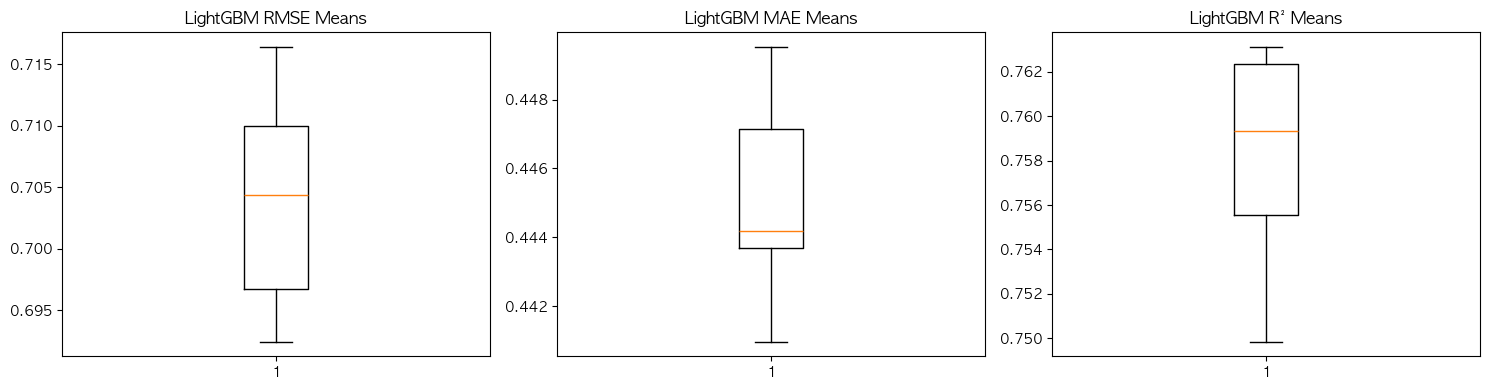

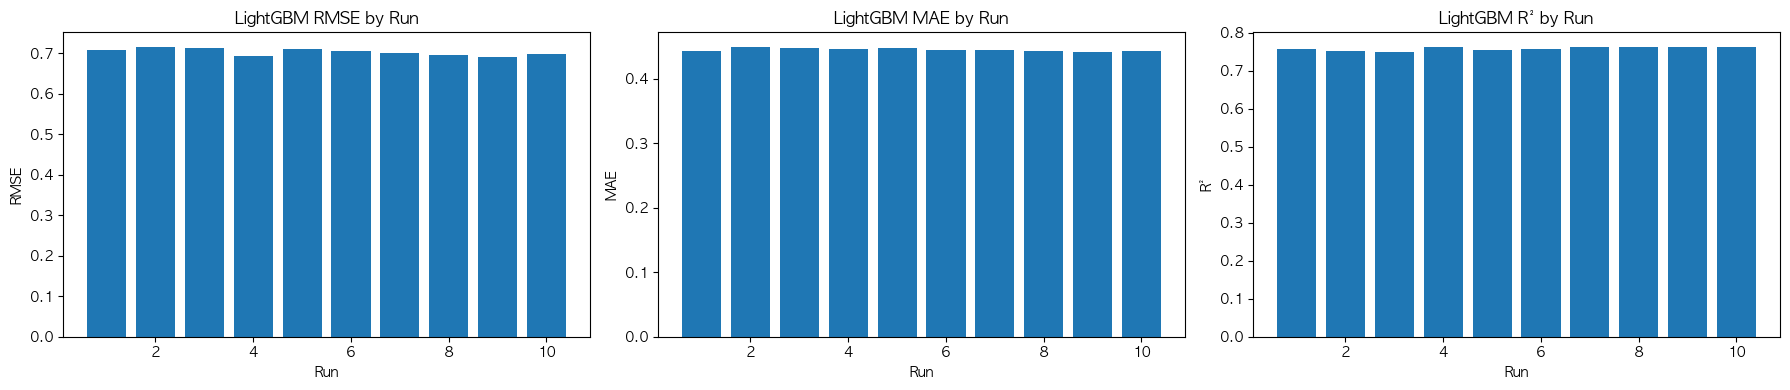


성능 지표 간 상관계수:
          MSE    RMSE     MAE      R2
MSE   1.0000  0.9942  0.7260 -0.9413
RMSE  0.9942  1.0000  0.7095 -0.9219
MAE   0.7260  0.7095  1.0000 -0.6802
R2   -0.9413 -0.9219 -0.6802  1.0000


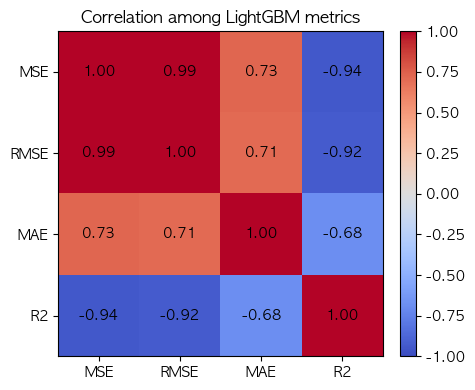

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def analyze_results(results):
    print("\n=== 3단계: LightGBM 결과 종합 및 분석 ===")
    rmse_means = [r['rmse_mean'] for r in results]
    mae_means  = [r['mae_mean']  for r in results]
    r2_means   = [r['r2_mean']   for r in results]
    mse_means  = [r['mse_mean']  for r in results]

    print(f"\n전체 {len(results)}개 모델 성능 요약:")
    print(f"RMSE 평균: {np.mean(rmse_means):.4f} ± {np.std(rmse_means):.4f}")
    print(f"MAE  평균: {np.mean(mae_means):.4f} ± {np.std(mae_means):.4f}")
    print(f"R²   평균: {np.mean(r2_means):.4f} ± {np.std(r2_means):.4f}")

    best_r2_idx  = int(np.argmax(r2_means))
    best_mse_idx = int(np.argmin(mse_means))
    print(f"\n최고 R² 모델: {best_r2_idx+1}번째 (R²={r2_means[best_r2_idx]:.4f})")
    print(f"최저 MSE 모델: {best_mse_idx+1}번째 (MSE={mse_means[best_mse_idx]:.4f}, RMSE={np.sqrt(mse_means[best_mse_idx]):.4f})")

    # --- Boxplot (분포)
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    axes[0].boxplot(rmse_means); axes[0].set_title('LightGBM RMSE Means')
    axes[1].boxplot(mae_means);  axes[1].set_title('LightGBM MAE Means')
    axes[2].boxplot(r2_means);   axes[2].set_title('LightGBM R² Means')
    plt.tight_layout(); plt.show()

    # --- Bar plot (비교)
    fig, axes = plt.subplots(1, 3, figsize=(18, 4))
    axes[0].bar(range(1, len(results)+1), rmse_means); axes[0].set_title('LightGBM RMSE by Run'); axes[0].set_xlabel('Run'); axes[0].set_ylabel('RMSE')
    axes[1].bar(range(1, len(results)+1), mae_means);  axes[1].set_title('LightGBM MAE by Run');  axes[1].set_xlabel('Run'); axes[1].set_ylabel('MAE')
    axes[2].bar(range(1, len(results)+1), r2_means);   axes[2].set_title('LightGBM R² by Run');   axes[2].set_xlabel('Run'); axes[2].set_ylabel('R²')
    plt.tight_layout(); plt.show()

    # --- 상관행렬
    corr_df = pd.DataFrame({
        'MSE': mse_means, 'RMSE': rmse_means, 'MAE': mae_means, 'R2': r2_means
    })
    corr = corr_df.corr()
    print("\n성능 지표 간 상관계수:\n", corr.round(4))

    plt.figure(figsize=(5,4))
    im = plt.imshow(corr, cmap='coolwarm', vmin=-1, vmax=1)
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.xticks(range(len(corr.columns)), corr.columns)
    plt.yticks(range(len(corr.columns)), corr.columns)
    for i in range(len(corr.columns)):
        for j in range(len(corr.columns)):
            plt.text(j, i, f'{corr.iloc[i, j]:.2f}', ha='center', va='center',
                     color='black', fontweight='bold')
    plt.title('Correlation among LightGBM metrics')
    plt.tight_layout(); plt.show()

    return best_r2_idx, best_mse_idx

best_r2_idx, best_mse_idx = analyze_results(results)

In [14]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import platform

# OS별 한글 폰트 설정
if platform.system() == 'Darwin':  # Mac
    plt.rc('font', family='AppleGothic')
elif platform.system() == 'Windows':  # Windows
    plt.rc('font', family='Malgun Gothic')
else:  # Linux (예: Colab)
    plt.rc('font', family='NanumGothic')

plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지



=== LightGBM 특성 중요도 분석 ===
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000315 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1084
[LightGBM] [Info] Number of data points in the train set: 3359, number of used features: 50
[LightGBM] [Info] Start training from score 8.052170

상위 10개 특성 중요도:


,original_feature,importance
58,ARRIVAL_DELAY_MIN_LOG,1898
0,DSPT_REQ_HR,1372
1,HR_UNIT_ARTMP,1291
2,HR_UNIT_HUM,840
60,FRSTN_GRNDS_DSTNC_LOG,754
59,CNTR_GRNDS_DSTNC_LOG,614
4,MONTH,323
26,CTPV_NM_경기도,164
43,FND_IGTN_PSTN_NM_산아래,107
3,WSPD_BIN,99


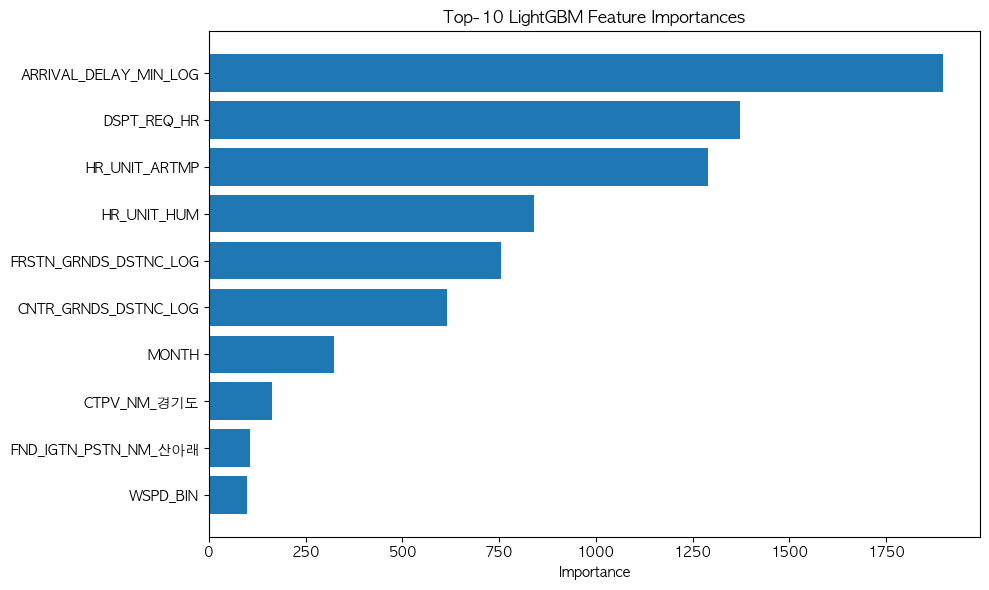

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import re

# 1) LightGBM-safe 컬럼명 변환 + 중복 처리
def make_lgbm_safe_columns(df):
    orig_cols = list(df.columns)
    safe_cols = (
        pd.Series(orig_cols)
        .str.replace(r'[^A-Za-z0-9_]+', '_', regex=True)   # 허용문자 외엔 _
        .str.replace(r'^[0-9]', lambda m: f'f_{m.group(0)}', regex=True)  # 숫자로 시작 → 접두사 f_
    )

    # 중복 처리
    counts = {}
    unique_cols = []
    for col in safe_cols:
        if col in counts:
            counts[col] += 1
            new_col = f"{col}__{counts[col]}"
        else:
            counts[col] = 0
            new_col = col
        unique_cols.append(new_col)

    df_safe = df.copy()
    df_safe.columns = unique_cols
    name_map = dict(zip(unique_cols, orig_cols))  # 안전이름 → 원래이름 매핑
    return df_safe, unique_cols, name_map

# 2) 데이터 변환
X_safe, feature_cols_safe, name_map = make_lgbm_safe_columns(X)

print("\n=== LightGBM 특성 중요도 분석 ===")

# 3) 최적 모델(best_model)로 전체 데이터 적합
best_model.fit(X_safe, y)

# 4) 중요도 계산 (안전이름 기준)
fi_safe = pd.DataFrame({
    'safe_feature': feature_cols_safe,
    'importance': best_model.feature_importances_
}).sort_values('importance', ascending=False)

# 5) 원래 이름 복원
fi_safe['original_feature'] = fi_safe['safe_feature'].map(name_map)

# 6) 상위 10개 출력
print("\n상위 10개 특성 중요도:")
display(fi_safe[['original_feature', 'importance']].head(10))

# 7) 시각화
plt.figure(figsize=(10, 6))
top = fi_safe.head(10)
plt.barh(range(len(top)), top['importance'])
plt.yticks(range(len(top)), top['original_feature'])
plt.gca().invert_yaxis()
plt.xlabel('Importance')
plt.title('Top-10 LightGBM Feature Importances')
plt.tight_layout()
plt.show()


In [27]:
# === K-fold CV + 평균 종속변수 시간 계산 (로그/원단위 모두) — 출력 단위: 분/시간 선택 ===
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from lightgbm import LGBMRegressor

# -----------------------
# 설정
# -----------------------
TARGET_IS_LOG = True        # 타깃이 로그변환 컬럼이면 True
TIME_UNIT     = "min"       # 출력 단위: 'sec' | 'min' | 'hour'
SHOW_BOTH     = True        # True면 보조 단위도 함께 표시

# 모델 하이퍼파라미터 (LightGBM)
lgbm_params = dict(
    n_estimators=300,
    learning_rate=0.05,
    num_leaves=31,
    min_child_samples=20,
    random_state=42,
    n_jobs=-1
)

assert 'X' in globals() and 'y' in globals(), "먼저 X, y를 준비하세요."

X_np = np.asarray(X)
y_np = np.asarray(y).astype(float)

# -----------------------
# 헬퍼
# -----------------------
def to_unit(v_sec, unit="sec"):
    if unit == "min":  return v_sec / 60.0
    if unit == "hour": return v_sec / 3600.0
    return v_sec

def unit_label(unit):
    return {"sec":"초", "min":"분", "hour":"시간"}[unit]

def hhmm(v_sec):
    v_sec = float(v_sec)
    h = int(v_sec // 3600)
    m = int((v_sec % 3600) // 60)
    return f"{h}h {m}m"

def show_with_both(name, v_sec):
    main_val = to_unit(v_sec, TIME_UNIT)
    s = f"{name}: {main_val:,.2f} {unit_label(TIME_UNIT)}"
    if SHOW_BOTH:
        other_unit = {"sec":"min", "min":"hour", "hour":"min"}[TIME_UNIT]
        other_val  = to_unit(v_sec, other_unit)
        s += f"  |  ({other_val:,.2f} {unit_label(other_unit)}, ~{hhmm(v_sec)})"
    return s

# -----------------------
# K-fold CV (로그 스케일 성능)
# -----------------------
kf = KFold(n_splits=5, shuffle=True, random_state=42)

y_true_list_log, y_pred_list_log = [], []
rmse_list_log, mae_list_log, r2_list_log = [], [], []

for fold_idx, (tr, va) in enumerate(kf.split(X_np), start=1):
    X_tr, X_va = X_np[tr], X_np[va]
    y_tr, y_va = y_np[tr], y_np[va]

    model = LGBMRegressor(**lgbm_params)
    model.fit(X_tr, y_tr)
    y_va_pred = model.predict(X_va)

    rmse_log = np.sqrt(mean_squared_error(y_va, y_va_pred))
    mae_log  = mean_absolute_error(y_va, y_va_pred)
    r2_log   = r2_score(y_va, y_va_pred)

    rmse_list_log.append(rmse_log)
    mae_list_log.append(mae_log)
    r2_list_log.append(r2_log)

    y_true_list_log.append(y_va)
    y_pred_list_log.append(y_va_pred)

    print(f"[Fold {fold_idx}] RMSE={rmse_log:.4f} | MAE={mae_log:.4f} | R²={r2_log:.4f}")

# -----------------------
# fold 전체 합치기
# -----------------------
y_all_true_log = np.concatenate(y_true_list_log)
y_all_pred_log = np.concatenate(y_pred_list_log)

print("\n=== CV 평균(로그 스케일, y의 현재 스케일 기준) ===")
print(f"RMSE(mean±std): {np.mean(rmse_list_log):.4f} ± {np.std(rmse_list_log):.4f}")
print(f"MAE (mean±std): {np.mean(mae_list_log):.4f} ± {np.std(mae_list_log):.4f}")
print(f"R²  (mean±std): {np.mean(r2_list_log):.4f} ± {np.std(r2_list_log):.4f}")

# -----------------------
# 원 단위(초)로 복원 후 통계/지표
# -----------------------
if TARGET_IS_LOG:
    y_all_true_sec = np.expm1(y_all_true_log)
    y_all_pred_sec = np.expm1(y_all_pred_log)
else:
    y_all_true_sec = y_all_true_log
    y_all_pred_sec = y_all_pred_log

# 실제/예측 통계
mean_true    = float(np.mean(y_all_true_sec))
median_true  = float(np.median(y_all_true_sec))
std_true     = float(np.std(y_all_true_sec))

mean_pred    = float(np.mean(y_all_pred_sec))
median_pred  = float(np.median(y_all_pred_sec))  

# 오차 지표 (원 단위 기준)
rmse_orig = float(np.sqrt(mean_squared_error(y_all_true_sec, y_all_pred_sec)))
mae_orig  = float(mean_absolute_error(y_all_true_sec, y_all_pred_sec))
r2_orig   = float(r2_score(y_all_true_sec, y_all_pred_sec))  # 역변환 후 R² 참고용

print(f"\n=== 실제 종속변수 통계 (표시 단위 → {unit_label(TIME_UNIT)}) ===")
print(show_with_both("평균",     mean_true))
print(show_with_both("중앙값",   median_true))
print(show_with_both("표준편차", std_true))

print(f"\n=== 예측 통계 (표시 단위 → {unit_label(TIME_UNIT)}) ===")
print(show_with_both("예측 평균",    mean_pred))
print(show_with_both("예측 중앙값",  median_pred))
print(show_with_both("평균 차이(예측-실제)",   mean_pred - mean_true))
print(show_with_both("중앙값 차이(예측-실제)", median_pred - median_true))

print(f"\n=== 원래 단위에서의 오차 지표 (참고) ===")
print(show_with_both("RMSE", rmse_orig))
print(show_with_both("MAE",  mae_orig))
print(f"R²  : {r2_orig:.4f}  (역변환 후 R²는 참고용)")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000342 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1075
[LightGBM] [Info] Number of data points in the train set: 2687, number of used features: 49
[LightGBM] [Info] Start training from score 8.067854
[Fold 1] RMSE=0.6798 | MAE=0.4443 | R²=0.7728
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000308 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1068
[LightGBM] [Info] Number of data points in the train set: 2687, number of used features: 48
[LightGBM] [Info] Start training from score 8.051512
[Fold 2] RMSE=0.7016 | MAE=0.4366 | R²=0.7475
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000266 sec